# Introduction to atomman: Gamma Surface Plotting

__Lucas M. Hale__, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), _Materials Science and Engineering Division, NIST_.
    
[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm) 

## 1. Introduction

This Notebook outlines the GammaSurface class and the various stacking fault plots that it can generate.  See the [04.4 Stacking Fault Generation Notebook](04.4._Stacking_Fault_Generation.html) for generating systems containing stacking faults.

**Library Imports**

In [1]:
# Standard Python libraries
from __future__ import (absolute_import, print_function,
                        division, unicode_literals)
import os
import datetime

# http://www.numpy.org/
import numpy as np

# https://github.com/usnistgov/atomman
import atomman as am
import atomman.unitconvert as uc

# https://matplotlib.org/
import matplotlib.pyplot as plt
%matplotlib inline

# Show atomman version
print('atomman version =', am.__version__)

# Show date of Notebook execution
print('Notebook executed on', datetime.date.today())

atomman version = 1.2.6
Notebook executed on 2019-04-23


## 2. Underlying theory

Generalized stacking fault energy maps ($\gamma$-surfaces) provide 2D maps of the stacking fault energy associated with arbitrary shifts along a crystallographic fault plane. Typically, the fault plane corresponds to one of the crystal's slip planes and the stacking fault energies and pathways influence dislocation structures and dislocation slip.

A $\gamma$-surface is defined by the crystal and the fault plane. Starting in an unfaulted configuration, the atoms on one side of the fault plane are shifted by a vector $\mathbf{d}$ which is within the fault plane.  The generalized stacking fault energy for a given shift, $\gamma_{gsf}(\mathbf{d})$, is computed as the difference in potential energy, $U$ of the shifted configuration relative to the corresponding unshifted configuration ($\mathbf{d}=\mathbf{0}$) divided by the fault plane area, $A_{fault}$

$$\gamma_{gsf}(\mathbf{d}) = \frac{U(\mathbf{d}) - U(\mathbf{0})}{A_{fault}}$$

The measured $\gamma_{gsf}$ values may be "unrelaxed", in which case no atomic relaxations are allowed, or "relaxed", in which atoms are allowed to move only in the direction normal to the slip plane to lower the system's energy.  For relaxed $\gamma$-surfaces, the relaxation distance, $\delta_{\bot}$, can be evaluated using the centers of mass of the atoms on the two sides of the fault plane, $\mathbf{R}^+$ and $\mathbf{R}^-$, and measuring how the plane normal component $\bot$ changes relative to the unshifted state

$$ \mathbf{R} = \frac{\sum_{i=1}^{n}m_i\mathbf{r_i}}{\sum_{i=1}^{n}m_i} $$

$$ \delta_{\bot} = \left(R_{\bot}^+(\mathbf{d}) - R_{\bot}^-(\mathbf{d})\right) - \left(R_{\bot}^+(\mathbf{0}) - R_{\bot}^-(\mathbf{0})\right)$$

As a $\gamma$-surface is a 2D map, the applied shift, $\mathbf{d}$, can be expressed using two non-parallel vectors within the fault plane, $\mathbf{a_1}$ and $\mathbf{a_2}$. Taking $\mathbf{a_1}$ and $\mathbf{a_2}$ as lattice vectors (i.e. vectors between two symetrically identical lattice sites) will define a 2D cell encompassing all possible unique stacking fault shifts for the fault plane.  $\mathbf{d}$ can then be represented using fractional coordinates, $a_1$ and $a_2$, relative to $\mathbf{a_1}$ and $\mathbf{a_2}$

$$ \mathbf{d} = a_1 \mathbf{a_1} + a_2 \mathbf{a_2} $$

The $\gamma_{gsf}$ (and $\delta_{\bot}$) data is fit to interpolation models to provide continuous values between the measured points. Two interpolation models are fit to the data

- A multiquadric radial basis function interpolation.

- A nearest-value interpolation. 

To perform the fits, the data is replicated across the periodic bounds by shifting the $a_1$ and $a_2$ values by $\pm 1$. The unique $a_1$ and $a_2$ values less than and closest to 0 and greater than and closest to 1 are identified, and all measured points between these two limits are fed into the fitting models to ensure smooth representation across the bounds.  Any arbitrary shift values $\mathbf{d}$ are converted into $a_1$ and $a_2$ values between 0 and 1 for use in retrieving values from the fitted models.




## 3. Defining gamma surface data

The atomman.defect.GammaSurface class offers interpolation and plotting options for generalized stacking fault data.

### 3.1. Setting values

The stacking fault data can be set directly either during class initialization or by using the GammaSurface.set() method.

Parameters: 

- **a1vect** (*array-like object of length 3*) The a1 shifting vector.  If box is given, a1vect is taken as a crystal lattice vector, otherwise as a Cartesian vector.

- **a2vect** (*array-like object of length 3*) The a2 shifting vector.  If box is given, a1vect is taken as a crystal lattice vector, otherwise as a Cartesian vector.

- **a1** (*array-like object of length N*) List of fractional coordinates along a1vect corresponding to the E_gsf (and delta) values.

- **a2** (*array-like object of length N*) List of fractional coordinates along a2vect corresponding to the E_gsf (and delta) values.

- **E_gsf** (*array-like object of length N*) List of generalized stacking fault energies for the positions associated with the corresponding (a1, a2) fractional coordinates.

- **box** (*atomman.Box, optional*) Defines unit cell box dimensions for conversion between crystal lattice and Cartesian vectors.   If not given, will be set as a square unit box, thus no conversion will occur (i.e. a1vect, a2vect will be Cartesian).
 
- **delta** (*array-like object of length N, optional*) List of change in displacements normal to the fault plane for the positions associated with the corresponding (a1, a2) fractional coordinates.

In [2]:
# Parameters for an Al fcc 111 stacking fault
box = am.Box.cubic(a=4.05)
a1vect = np.array([ 0.0, -0.5, 0.5])
a2vect = np.array([-0.5,  0.0, 0.5])

# Measured 10x10 grid of generalized stacking fault data
a1 = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
a2 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9])
E_gsf = np.array([0.0, 0.0029058939813610372, 0.009967527110804493, 0.017519738232042618, 0.02326877602347241, 0.024857238534160123, 0.023268775651632455, 0.017519736773543945, 0.009967524907496488, 0.0029058924810454892, 0.002905902826409026, 0.010170484991190503, 0.020395839765219238, 0.02857152118868265, 0.03178495629206124, 0.031784956450315115, 0.028571520168478783, 0.02039583762836736, 0.010170482478274855, 0.002905901841404914, 0.009967530192814976, 0.020395832461598103, 0.030039341624311384, 0.03499075121321049, 0.035623194600430674, 0.034990751326409684, 0.030039340246909744, 0.020395829767056402, 0.00996752813917364, 0.005442627660468005, 0.017519724199952073, 0.02857150343353976, 0.034990743348520224, 0.03592784212518266, 0.03592784215629818, 0.03499074279491336, 0.02857150121277434, 0.017519721775032932, 0.009514898671668064, 0.009514899593174062, 0.0232687483392972, 0.03178492693594086, 0.0356231854288785, 0.03592784183810076, 0.0356231847471479, 0.03178492514910748, 0.023268746230323666, 0.013824846424357776, 0.009977732476889075, 0.013824847592818454, 0.02485720345681911, 0.03178492745336388, 0.03499074046179261, 0.034990739796816425, 0.03178492550813512, 0.024857201334750913, 0.01676686928265928, 0.011212312575301371, 0.011212312851260616, 0.01676687052602372, 0.023268735121708652, 0.028571479533944916, 0.030039311395541578, 0.028571478332115, 0.023268733384575076, 0.01676686336038317, 0.011665394999032198, 0.009542001938907512, 0.011665395298503193, 0.016766864450984627, 0.01751969265854646, 0.020395789107882645, 0.02039578854962875, 0.01751969169198577, 0.0138248287503132, 0.011212304552217006, 0.009542003199448295, 0.009542003267030008, 0.01121230456531103, 0.013824829275760646, 0.009967489607699194, 0.010170438602488702, 0.009967489756660933, 0.009514877089284066, 0.00997772373884573, 0.01121231277790565, 0.011665403430422714, 0.011212312514477638, 0.009977723519908976, 0.009514877022546862, 0.002905875619952831, 0.002905876133856328, 0.00544260634615841, 0.009514894878640063, 0.013824855189574535, 0.016766890288627673, 0.016766890134175035, 0.013824854547407091, 0.009514893889552352, 0.005442605088996296])
delta = np.array([0.0, 0.011894941077718713, 0.06191865285371456, 0.1415766284579707, 0.22842358541125485, 0.282206219272064, 0.2284235544133164, 0.1415765987454929, 0.06191862427468031, 0.01189493683759757, 0.011894848438886996, 0.0629409280849682, 0.14840372088448817, 0.25452232688216725, 0.3621481241787716, 0.36214800587557683, 0.2545222871757584, 0.1484036888707525, 0.06294091666707047, 0.011894840085245661, 0.06191878798732198, 0.1484038170673294, 0.2881199279026969, 0.48249932654951344, 0.5413359543921441, 0.48249927131236525, 0.28811989133388316, 0.1484037932659099, 0.061918771265423445, 0.009835687819675698, 0.14157693518040482, 0.254522319051242, 0.4824990362601138, 0.6302827111959264, 0.6302826961369146, 0.48249900006798185, 0.25452228247809927, 0.14157692680593925, 0.07923441797991693, 0.0792368011160356, 0.22842386790467195, 0.36214809791403013, 0.5413352450450137, 0.6302824324643996, 0.5413352033689005, 0.36214805943961714, 0.22842385961280165, 0.1538922572144994, 0.1255452665080643, 0.15389225701323284, 0.2822053601370609, 0.3621476945807043, 0.48249839619324497, 0.48249841821976425, 0.3621475014569544, 0.282206042554197, 0.20976312214005155, 0.16126457970799457, 0.161264573029003, 0.2097631029839686, 0.22842329159117902, 0.2545216032901987, 0.2881192172332252, 0.25452160642329424, 0.22842331429657214, 0.20976291263960256, 0.16924653271973433, 0.1339344003648133, 0.16924653200388384, 0.20976288146158595, 0.14157641838617963, 0.1484032606714738, 0.14840326888439748, 0.14157643972432687, 0.1538917694437707, 0.16126429037130663, 0.1339344251377188, 0.13393442185462412, 0.16126426357866386, 0.15389174152796237, 0.06191832083556825, 0.06294072780150906, 0.06191833269256186, 0.07923620173687063, 0.12554476892559663, 0.16126426421697637, 0.1692468825130593, 0.1612642441036236, 0.12554474048878994, 0.0792361769983625, 0.01189479365989321, 0.01189478954671408, 0.009834223780478268, 0.07923639077706035, 0.1538918423263027, 0.20976273646788535, 0.20976272444614175, 0.15389181461142165, 0.07923635694905862, 0.009834209898977875])

gamma = am.defect.GammaSurface(a1vect=a1vect, a2vect=a2vect, a1=a1, a2=a2,
                               E_gsf=E_gsf, box=box, delta=delta)

### 3.2. Class attributes

The GammaSurface class has the following attributes for the data

- **a1vect, a2vect** the two shifting vectors as given.

- **box** the unit cell box as given.

- **planenormal** a Cartesian vector normal to the fault plane.

- **data** a pandas.DataFrame tabulating the measured stacking fault data.  The data columns are

    - **a1** fractional coordinates along the a1vect.
    
    - **a2** fractional coordinates along the a2vect.
    
    - **E_gsf** generalized stacking fault energies measured for each (a1, a2) fault shift.
    
    - **delta** (optional) relaxation distances measured for each (a1, a2) fault shift.


In [3]:
print('gamma.a1vect ->', gamma.a1vect)
print('gamma.a2vect ->', gamma.a2vect)
print('gamma.planenormal ->', gamma.planenormal)
print('gamma.box ->')
print(gamma.box)

gamma.a1vect -> [ 0.  -0.5  0.5]
gamma.a2vect -> [-0.5  0.   0.5]
gamma.planenormal -> [-4.100625 -4.100625 -4.100625]
gamma.box ->
avect =  [ 4.050,  0.000,  0.000]
bvect =  [ 0.000,  4.050,  0.000]
cvect =  [ 0.000,  0.000,  4.050]
origin = [ 0.000,  0.000,  0.000]


In [4]:
gamma.data

,a1,a2,E_gsf,delta
0,0.0,0.0,0.000000,0.000000
1,0.1,0.0,0.002906,0.011895
2,0.2,0.0,0.009968,0.061919
3,0.3,0.0,0.017520,0.141577
4,0.4,0.0,0.023269,0.228424
5,0.5,0.0,0.024857,0.282206
6,0.6,0.0,0.023269,0.228424
7,0.7,0.0,0.017520,0.141577
8,0.8,0.0,0.009968,0.061919
9,0.9,0.0,0.002906,0.011895


### 3.3. Saving and loading data model

The GammaSurface.model() method allows for the saving and loading of a GammaSurface object's data as a JSON/XML data model.

Parameters
        
- **model** (*str, file-like object or DataModelDict, optional*) XML/JSON content to extract gamma surface energy from. If not given, model content will be generated.

- **length_unit** (*str, optional*) Units to report delta displacement values in when a new model is generated. Default value is 'angstrom'.
            
- **energyperarea_unit** (*str, optional*) Units to report fault energy values in when a new model is generated.  Default value is 'mJ/m^2'.
        
Returns

(*DataModelDict*) A data model containing the stacking fault data of the GammaSurface object.  Returned if model is not given.

#### 3.3.1. Save data model

Calling GammaSurface.model() without supplying the 'model' parameter will return  a data model of the content.

In [5]:
model = gamma.model()
print(model.json())

{"stacking-fault-map": {"box": {"avect": [4.05, 0.0, 0.0], "bvect": [0.0, 4.05, 0.0], "cvect": [0.0, 0.0, 4.05]}, "shift-vector-1": [0.0, -0.5, 0.5], "shift-vector-2": [-0.5, 0.0, 0.5], "stacking-fault-relation": {"shift-vector-1-fraction": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], "shift-vector-2-fraction": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,

#### 3.3.2. Load data model

The saved data can then be loaded by using the 'model' parameter when initializing a GammaSurface, or with the GammaSurface.model() method.

In [6]:
gamma = am.defect.GammaSurface(model=model)

## 4. Plotting methods

### 4.1. **E_gsf_line_plot()** 

Generates a line plot for the interpolated generalized stacking fault energy along a specified vector in the (a1, a2) plane.
        
Parameters
        
- **vect** (*numpy.array, optional*) Vector to plot the gsf along.  If box is set, this vect will be a lattice vector, otherwise it will be a Cartesian vector.  Must be in the plane defined by the GammaSurface object's a1vect and a2vect vectors.  Default value will use the set a1vect.

- **num** (*int, optional*) The number of points to evaluate the generalized stacking fault energy for.  Default value is 100 if smooth is True, otherwise is number of unique a1 values from 0 to 1.

- **smooth** (*bool, optional*) If True (default), then plot shows smooth interpolated values. If False, plot shows nearest raw data values.

- **length_unit** (*str, optional*) The unit of length to display the x-axis coordinates in. Default value is 'angstrom'.

- **energyperarea_unit** (*str, optional*) The unit of energy per area to display the stacking fault energies in. Default value is 'eV/angstrom^2'.
            
- **figsize** (*tuple, optional*) The x,y size of the figure to return.  Default value is (10, 6).
            
- **fig** (*matplotlib.figure, optional*) An existing figure object to add the new plot to.  If not given, a new figure is generated.
            
- **\*\*kwargs** (*dict, optional*) Additional keywords are passed into the underlying  matplotlib.pyplot.plot(). This allows control of such things like line color, style, etc.
        
Returns

(*matplotlib.figure*)

If vect is not given, will use a1vect

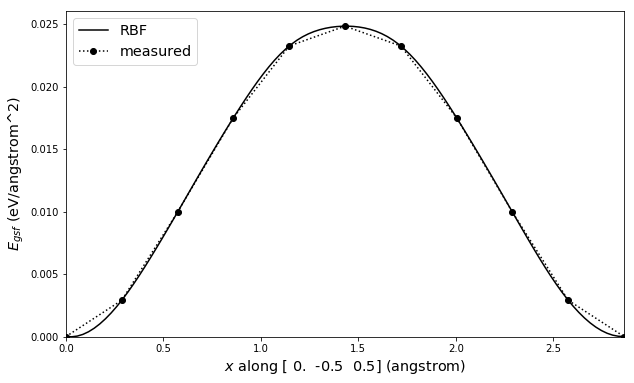

In [7]:
# Generate RBF interpolated plot
fig = gamma.E_gsf_line_plot(fmt='k-', label='RBF')

# Generate measured (nearest) plot and append to above
fig = gamma.E_gsf_line_plot(smooth=False, fmt='k:o', fig=fig, label='measured')

# Additional plot manipulations
plt.legend(loc=2, fontsize='x-large')
plt.show()

The important direction for fcc {111} stacking faults is a/2&lt;112&gt;, and energy values in mJ/m^2

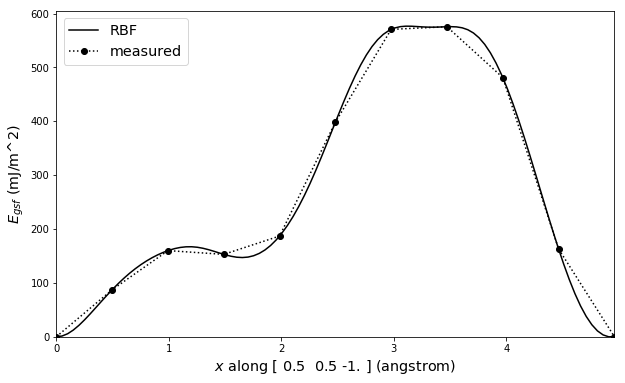

In [8]:
# Generate RBF interpolated plot
vect = np.array([1, 1, -2]) / 2
fig = gamma.E_gsf_line_plot(vect=vect, fmt='k-', energyperarea_unit='mJ/m^2', label='RBF')

# Generate measured (nearest) plot and append to above
fig = gamma.E_gsf_line_plot(vect=vect, smooth=False, fmt='k:o', 
                            energyperarea_unit='mJ/m^2', fig=fig, label='measured')

# Additional plot manipulations
plt.legend(loc=2, fontsize='x-large')
plt.show()

### 4.2. **delta_line_plot()** 

Generates a line plot for the interpolated relaxation distances along a specified vector in the (a1, a2) plane.
        
Parameters
        
- **vect** (*numpy.array, optional*) Vector to plot the gsf along.  If box is set, this vect will be a lattice vector, otherwise it will be a Cartesian vector.  Must be in the plane defined by the GammaSurface object's a1vect and a2vect vectors.  Default value will use the set a1vect.

- **num** (*int, optional*) The number of points to evaluate the generalized stacking fault energy for.  Default value is 100 if smooth is True, otherwise is number of unique a1 values from 0 to 1.

- **smooth** (*bool, optional*) If True (default), then plot shows smooth interpolated values. If False, plot shows nearest raw data values.

- **length_unit** (*str, optional*) The unit of length to display the x-axis coordinates in. Default value is 'angstrom'.
            
- **figsize** (*tuple, optional*) The x,y size of the figure to return.  Default value is (10, 6).
            
- **fig** (*matplotlib.figure, optional*) An existing figure object to add the new plot to.  If not given, a new figure is generated.
            
- **\*\*kwargs** (*dict, optional*) Additional keywords are passed into the underlying  matplotlib.pyplot.plot(). This allows control of such things like line color, style, etc.
        
Returns

(*matplotlib.figure*)

If vect is not given, will use a1vect

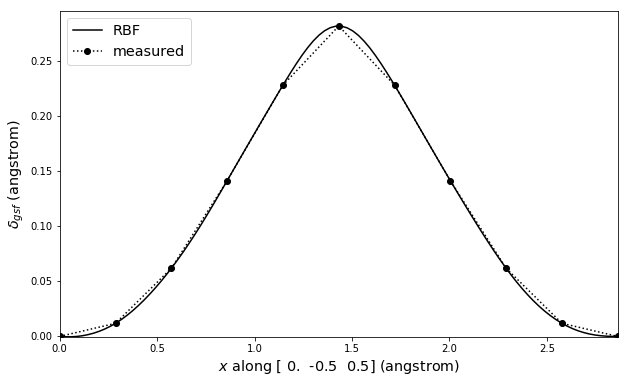

In [9]:
# Generate RBF interpolated plot
fig = gamma.delta_line_plot(fmt='k-', label='RBF')

# Generate measured (nearest) plot and append to above
fig = gamma.delta_line_plot(smooth=False, fmt='k:o', fig=fig, label='measured')

# Additional plot manipulations
plt.legend(loc=2, fontsize='x-large')
plt.show()

The important direction for fcc {111} stacking faults is a/2&lt;112&gt;

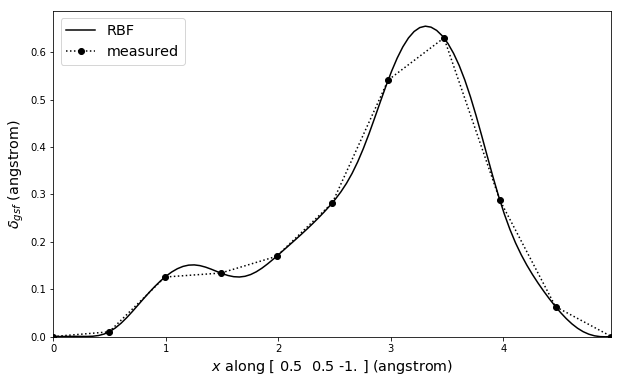

In [10]:
# Generate RBF interpolated plot
vect = np.array([1, 1, -2]) / 2
fig = gamma.delta_line_plot(vect=vect, fmt='k-', label='RBF')

# Generate measured (nearest) plot and append to above
fig = gamma.delta_line_plot(vect=vect, smooth=False, fmt='k:o', fig=fig, label='measured')

# Additional plot manipulations
plt.legend(loc=2, fontsize='x-large')
plt.show()

### 4.3. **E_gsf_surface_plot()** 

Creates a 2D surface plot from the stacking fault energy values.
        
Parameters
        
- **normalize** (*bool, optional*) Flag indicating if axes are Cartesian (False, default) or normalized by a1, a2 vectors (True).

- **smooth** (*bool, optional*) If True (default), then plot shows smooth interpolated values. If False, plot shows nearest raw data values.

- **a1vect** (*np.array, optional*) Crystal vector for the a1 vector to use for plotting.  Default value of None uses the saved a1vect.

- **a2vect** (*np.array, optional*) Crystal vector for the a2 vector to use for plotting.  Default value of None uses the saved a2vect.

- **xvect** (*numpy.array, optional*) Crystal vector to align with the plotting x-axis for  non-normalized plots.  If not given, this is taken as the Cartesian of a1vect.

- **length_unit** (*str, optional*) The unit of length to display non-normalized axes values in. Default value is 'angstrom'.

- **energyperarea_unit** (*str, optional*) The unit of energy per area to display the stacking fault energies in. Default value is 'eV/angstrom^2'.
            
- **numx** (*int, optional*) The number of plotting points to use along the x-axis.  Default value is 100.

- **numy** (*int, optional*) The number of plotting points to use along the y-axis.  Default value is 100.       
            
- **figsize** (*tuple or None, optional*) The figure's x,y dimensions.  If None (default), the values are scaled such that the x,y spacings are approximately equal, and the larger of the two values is set to 10.

- **\*\*kwargs** (*dict, optional*) Additional keywords are passed into the underlying matplotlib.pyplot.pcolormesh(). This allows control of such things like the colormap (cmap).
            
Returns
        
(*matplotlib.figure*)

Default setting

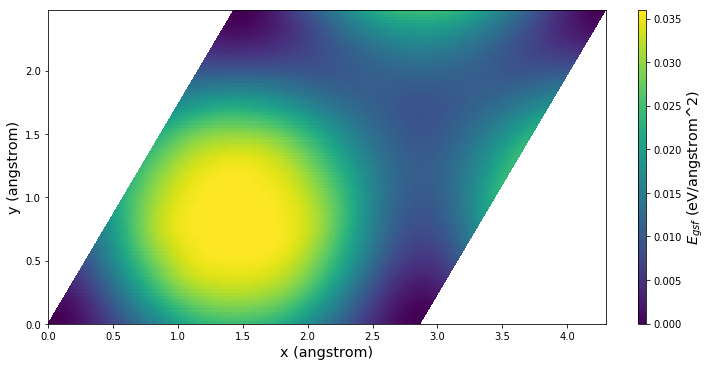

In [11]:
fig = gamma.E_gsf_surface_plot()
plt.show()

Plotting actual measured values

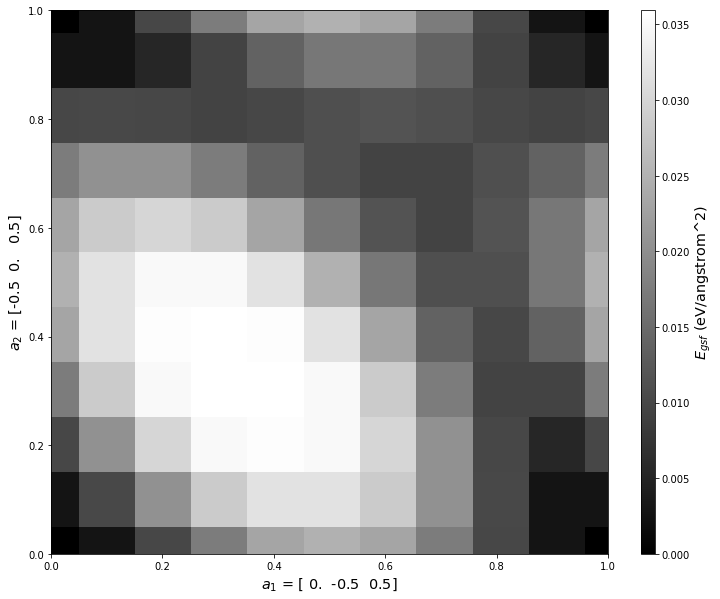

In [12]:
fig = gamma.E_gsf_surface_plot(smooth=False, normalize=True, cmap='gray')
plt.show()

Specifying a different a1vect and a2vect to use for plotting

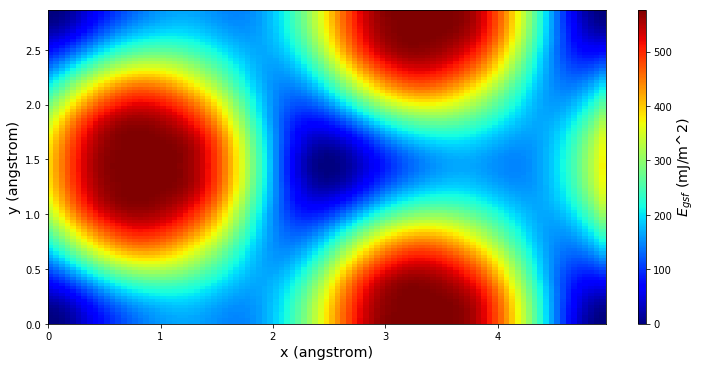

In [13]:
plot_a1vect = np.array([1, 1, -2]) / 2
plot_a2vect = np.array([1,-1, 0]) / 2

fig = gamma.E_gsf_surface_plot(a1vect=plot_a1vect, a2vect=plot_a2vect, energyperarea_unit='mJ/m^2', cmap='jet')
plt.show()

### 4.3. **delta_surface_plot()** 

Creates a 2D surface plot from the relaxation distance values.
        
Parameters
        
- **normalize** (*bool, optional*) Flag indicating if axes are Cartesian (False, default) or normalized by a1, a2 vectors (True).

- **smooth** (*bool, optional*) If True (default), then plot shows smooth interpolated values. If False, plot shows nearest raw data values.

- **a1vect** (*np.array, optional*) Crystal vector for the a1 vector to use for plotting.  Default value of None uses the saved a1vect.

- **a2vect** (*np.array, optional*) Crystal vector for the a2 vector to use for plotting.  Default value of None uses the saved a2vect.

- **xvect** (*numpy.array, optional*) Crystal vector to align with the plotting x-axis for  non-normalized plots.  If not given, this is taken as the Cartesian of a1vect.

- **length_unit** (*str, optional*) The unit of length to display non-normalized axes values in. Default value is 'angstrom'.
            
- **numx** (*int, optional*) The number of plotting points to use along the x-axis.  Default value is 100.

- **numy** (*int, optional*) The number of plotting points to use along the y-axis.  Default value is 100.       
            
- **figsize** (*tuple or None, optional*) The figure's x,y dimensions.  If None (default), the values are scaled such that the x,y spacings are approximately equal, and the larger of the two values is set to 10.

- **\*\*kwargs** (*dict, optional*) Additional keywords are passed into the underlying matplotlib.pyplot.pcolormesh(). This allows control of such things like the colormap (cmap).
            
Returns
        
(*matplotlib.figure*)

Default setting

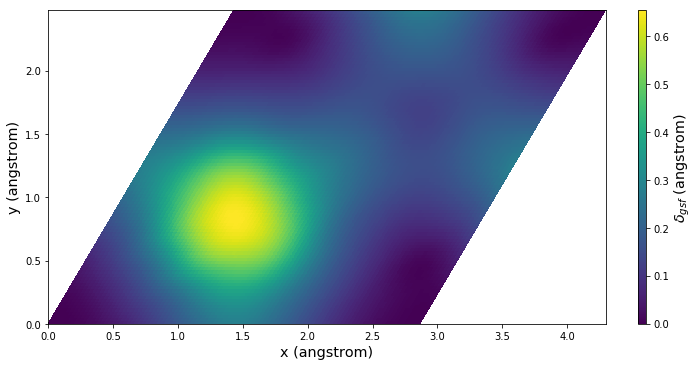

In [14]:
fig = gamma.delta_surface_plot()
plt.show()

Plotting actual measured values

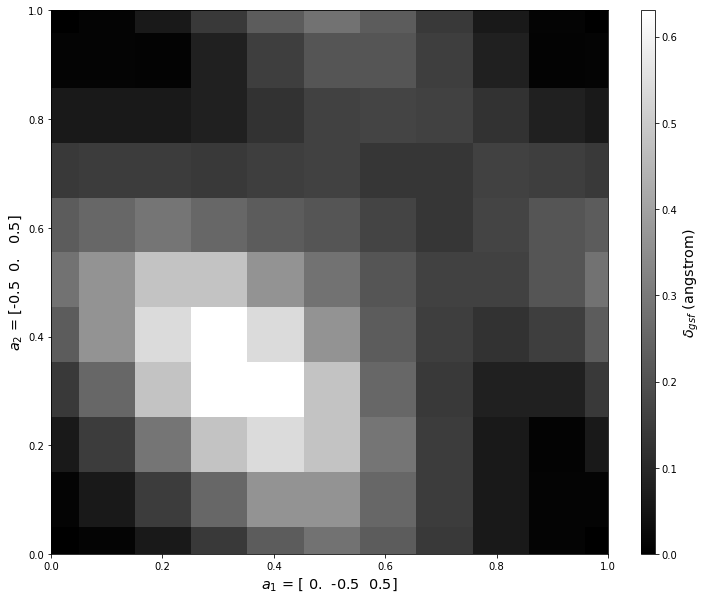

In [15]:
fig = gamma.delta_surface_plot(smooth=False, normalize=True, cmap='gray')
plt.show()

Specifying a different a1vect and a2vect to use for plotting

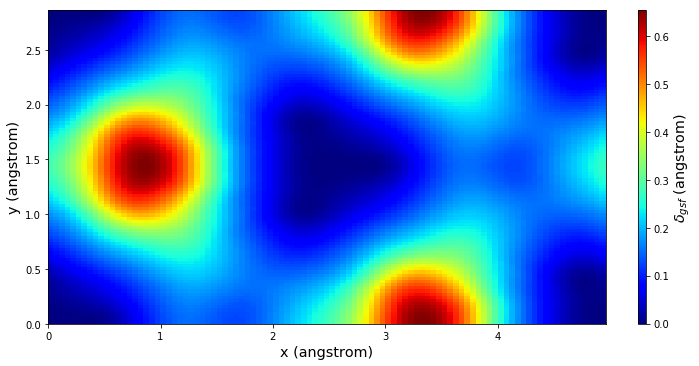

In [16]:
plot_a1vect = np.array([1, 1, -2]) / 2
plot_a2vect = np.array([1,-1, 0]) / 2

fig = gamma.delta_surface_plot(a1vect=plot_a1vect, a2vect=plot_a2vect, cmap='jet')
plt.show()

## 5. Utility methods

The remaining class methods are utility methods for generating the plots.  Many are focused on transforming between different coordinate systems:

1. (a1, a2) : fractional coordinates along a1vect and a2vect.  

2. pos : Cartesian position coordinates. 

3. (x, y) : plotting coordinates.

Transforming from (a1, a2) to pos requires a1vect, a2vect, and optionally the box.  Transforming from pos to (x, y) requires specifying which Cartesian vector to align with the x-axis of the plot. 

### 5.1 E_gsf()

Returns values for generalized stacking fault energy interpolated from the raw data.  Values can be obtained relative to a1, a2 fractional coordinates, x, y plotting coordinates, or pos Cartesian coordinates.
        
Parameters

- **a1** (*float(s), optional*) Fractional coordinate(s) along a1vect.

- **a2** (*float(s), optional*) Fractional coordinate(s) along a2vect.

- **pos** (*np.array, optional*) 3D Cartesian position vector(s).

- **x** (*float(s), optional*) Plotting x coordinate(s).

- **y** (*float(s), optional*) Plotting y coordinate(s).

- **a1vect** (*np.array, optional*) Vector for the a1 fractional coordinates.  Default value of None uses the saved a1vect.

- **a2vect** (*np.array, optional*) Vector for the a2 fractional coordinates.  Default value of None uses the saved a2vect.

- **xvect** (*np.array, optional*) Cartesian vector corresponding to the plotting x-axis. If None (default), this is taken as the Cartesian of a1vect.

- **smooth** (*bool, optional*) If True (default) the returned values are smoothed using a RBF fit. If False, the closest measured values are returned.

Returns 

- (*float or numpy.ndarray*) the energy values.

In [17]:
closetostable = gamma.E_gsf(a1=2/3, a2=2/3)
print(uc.get_in_units(closetostable, 'mJ/m^2'), 'mJ/m^2')

146.97820949525268 mJ/m^2


### 5.2 delta()

Returns values for the relaxation distance interpolated from the raw data.  Values can be obtained relative to a1, a2 fractional coordinates, x, y plotting coordinates, or pos Cartesian coordinates.
        
Parameters

- **a1** (*float(s), optional*) Fractional coordinate(s) along a1vect.

- **a2** (*float(s), optional*) Fractional coordinate(s) along a2vect.

- **pos** (*np.array, optional*) 3D Cartesian position vector(s).

- **x** (*float(s), optional*) Plotting x coordinate(s).

- **y** (*float(s), optional*) Plotting y coordinate(s).

- **a1vect** (*np.array, optional*) Vector for the a1 fractional coordinates.  Default value of None uses the saved a1vect.

- **a2vect** (*np.array, optional*) Vector for the a2 fractional coordinates.  Default value of None uses the saved a2vect.

- **xvect** (*np.array, optional*) Cartesian vector corresponding to the plotting x-axis. If None (default), this is taken as the Cartesian of a1vect.

- **smooth** (*bool, optional*) If True (default) the returned values are smoothed using a RBF fit. If False, the closest measured values are returned.

Returns 

- (*float or numpy.ndarray*) the relaxation distance values.

In [18]:
closetostable = gamma.delta(a1=2/3, a2=2/3)
print(uc.get_in_units(closetostable, 'angstrom'), 'angstrom')

0.12560157787390214 angstrom


### 5.3 Conversion methods

Parameters as defined above

- **a12_to_pos(a1, a2, a1vect=None, a2vect=None)**

- **pos_to_xy(pos, xvect=None)**

- **a12_to_xy(a1, a2, a1vect=None, a2vect=None, xvect=None)**

- **pos_to_a12(pos, a1vect=None, a2vect=None)**

- **xy_to_pos(x, y, xvect=None)**

- **xy_to_a12(x, y, a1vect=None, a2vect=None, xvect=None)**